In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt

import prfpy
from scipy.io import loadmat
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

In [10]:
import cortex.polyutils


subject = 'hcp_999999'

# First we need to import the surfaces for this subject
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "inflated")]

In [11]:
def psc(data):
  
  # crudely checking whether psc hasn't already happened, in which case do nothing
    if np.mean(data) < 0.5:
        return data
    return ((data.T/np.median(data, 1)).T - 1) * 100

import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def split_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

#     data = np.concatenate([l, r])
    return l, r



In [5]:
s1_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s1_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")
s2_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s2_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")

In [79]:
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import matplotlib.animation as animation

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

new_dms[5:,:,:].shape

(115, 100, 100)

In [7]:
np.save('/tank/klundert/projects/cfdn/data/CF_fit_utils/prf_dm.npy', new_dms)

In [14]:
prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

In [15]:
surround_amplitude_grid=np.array([0.05,0.2,0.4,0.7,1,3], dtype='float32')
surround_size_grid=np.array([3,5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

In [17]:
from scipy.optimize import LinearConstraint, NonlinearConstraint

gauss_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (0, 1000),  # prf amplitude
                (0, 0)]  # bold baseline



norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (0, 1000),  # prf amplitude
                (0, 0),  # bold baseline
                (0, 1000),  # surround amplitude
                (eps, 3*ss),  # surround size
                (0, 1000),  # neural baseline
                (1e-6, 1000)]  # surround baseline


constraints_gauss, constraints_css, constraints_dog, constraints_norm = [],[],[],[]
A_ssc_norm = np.array([[0,0,-1,0,0,0,1,0,0]])
    
constraints_norm.append(LinearConstraint(A_ssc_norm, lb=0, ub=+inf))


# CF_bounds = [(0.1, 45),  # sigmas
#                 (0, 1000),  # beta
#                 (0, 0.0001), # baseline
#                 (0, 0)] # vert


# DNCF_bounds = [(0.1, 50),  # sigmas
#                 (0, 1000),  # prf amplitude
#                 (0, 0.0001), # baseline (A)
#                 (0, 0), # vert
#                 (0, 1000), # srf amplitude (C)
#                 (0.3, 100), # surround sigma 
#                 (0, 1000), # neural baseline (B)
#                 (1e-6, 1000)] # surround baseline (D)

In [20]:
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

V1_mask = np.concatenate([maskL,maskR])

In [80]:
ss

17.824869939045477

In [89]:
s2_f = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_sub-01.npy')
s2_f2 = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_sub-01.npy')

In [ ]:
gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')

gf_P = Iso2DGaussianFitter(data=get_cortex(np.nan_to_num(s2_f))[V1_mask], model=gg, n_jobs=30, fit_css=False)
gf_P.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 n_batches=60)

gf_P.iterative_fit(rsq_threshold=-1, verbose=True, bounds=gauss_bounds)

# gf_P.crossvalidate_fit(s2_f2, single_hrf=False)

# np.save("/scratch/2021/nprf_ss/derivatives/prf-fits/sub-01/gaussian-prf/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy", gf_P.iterative_search_params)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/tank/klundert/anaconda3/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.35682D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00   1.357D+01
  F =   13.568179182373182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.0

/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nil

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.98138D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00   3.981D+01
  F =   39.813778584101037     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.0

/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03082D+01    |proj g|=  1.85010D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93568D+01    |proj g|=  3.03824D+00

At iterate    1    f=  1.63754D+01    |proj g|=  2.20560D+00

At iterate    1    f=  2.74333D+01    |proj g|=  4.42859D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        

/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38509D+02    |proj g|=  1.48801D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  8.92006D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00   8.920D+01
  F =   89.200588923157085     

CONVERGENCE: NORM_OF_PROJE

[Parallel(n_jobs=30)]: Done 990 tasks      | elapsed:    5.0s


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27662D+01    |proj g|=  1.06641D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.46820D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00   3.468D+01
  F =   34.682021797449778     

CONVERGENCE: NORM_OF_PROJE

[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:    7.4s


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.02595D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00   3.026D+01
  F =   30.259497880597358     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.4

[Parallel(n_jobs=30)]: Done 2890 out of 2890 | elapsed:    8.3s finished


In [32]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

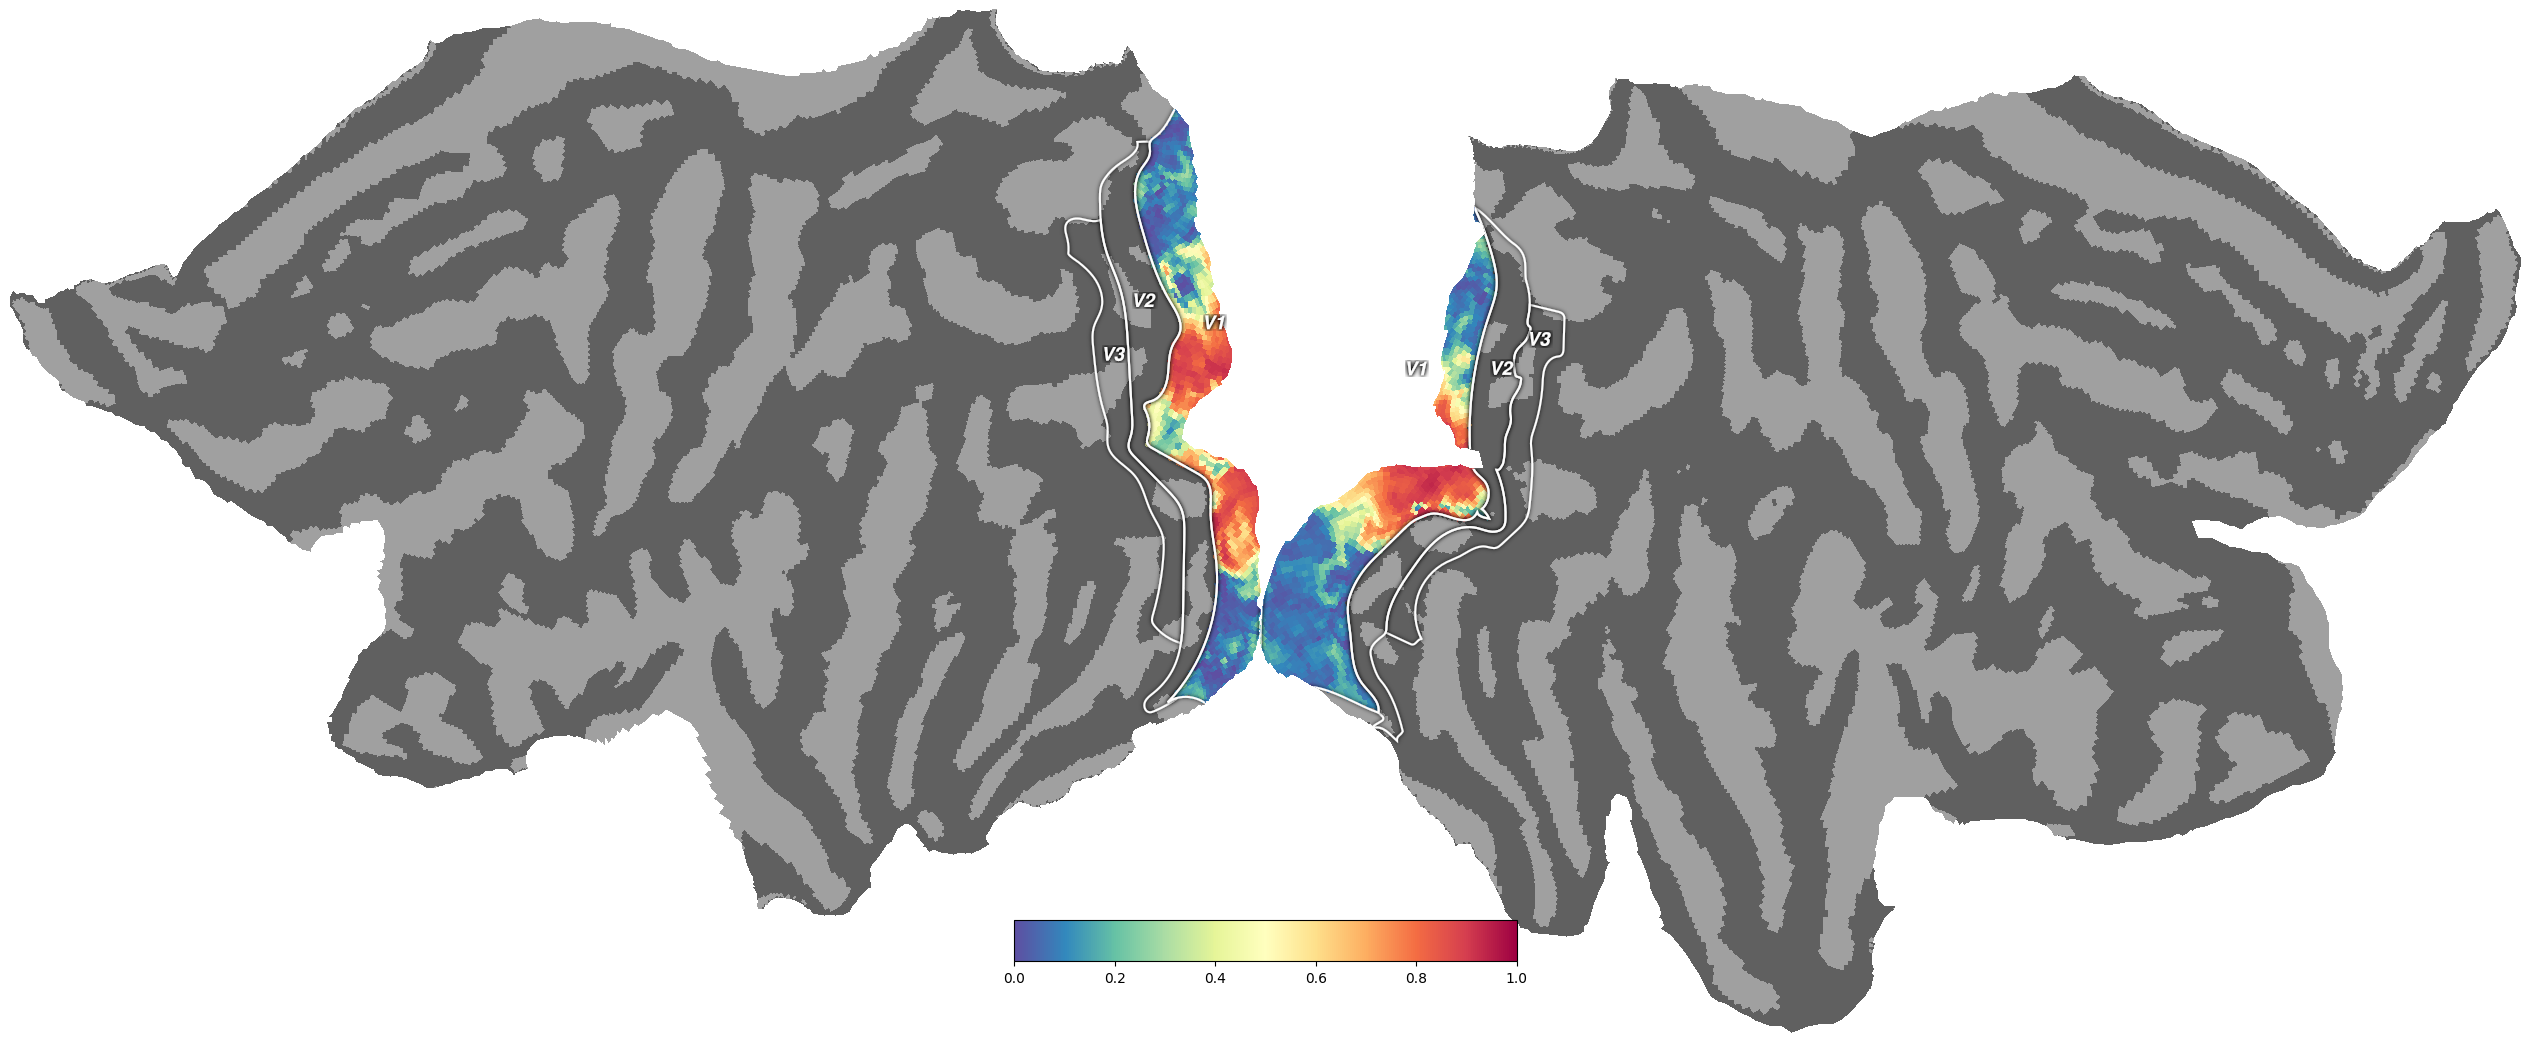

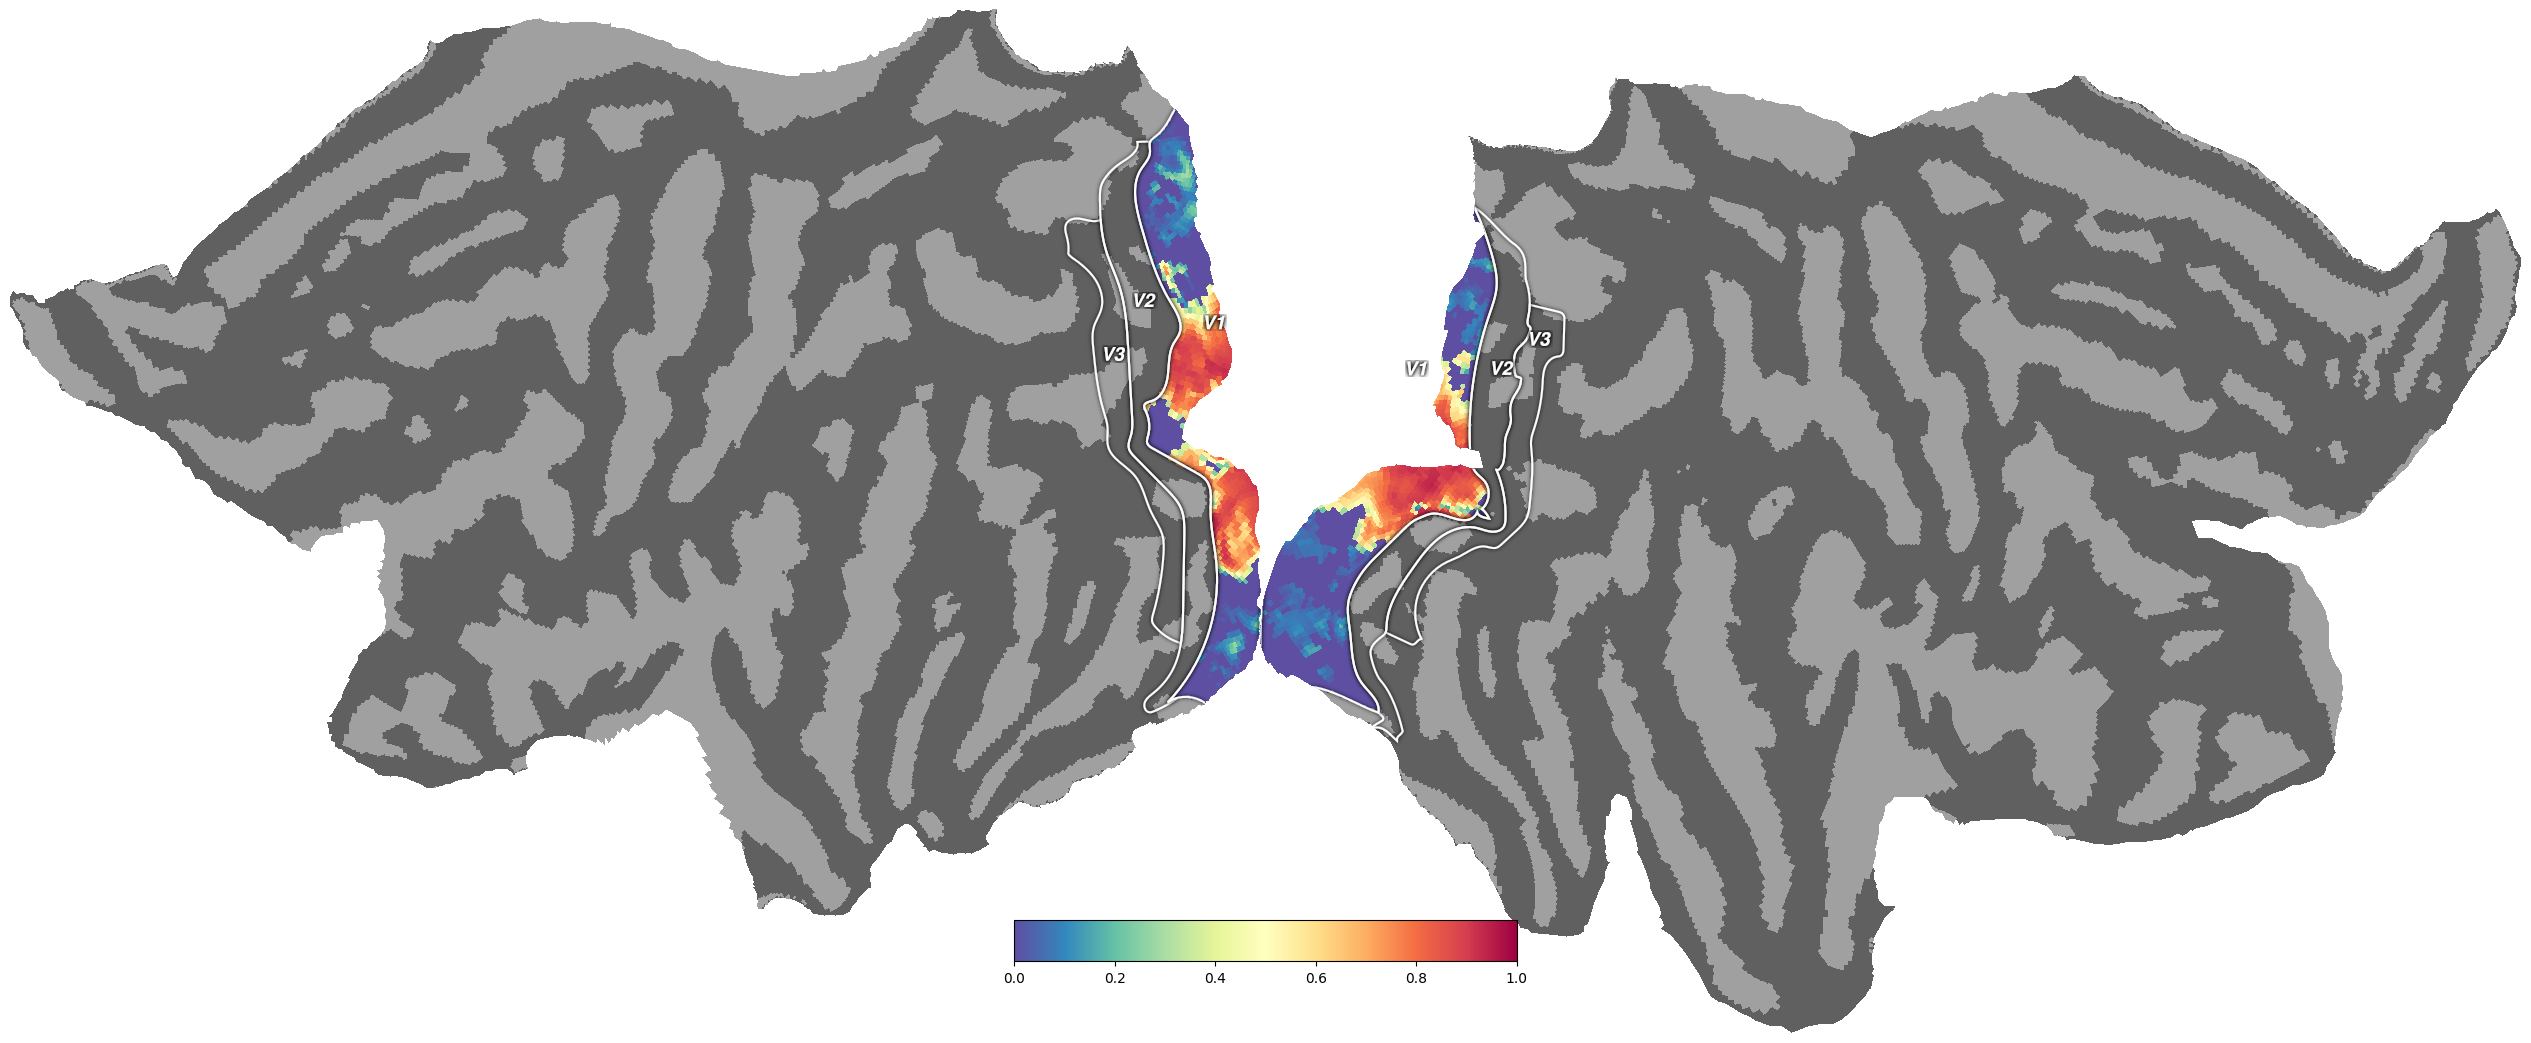

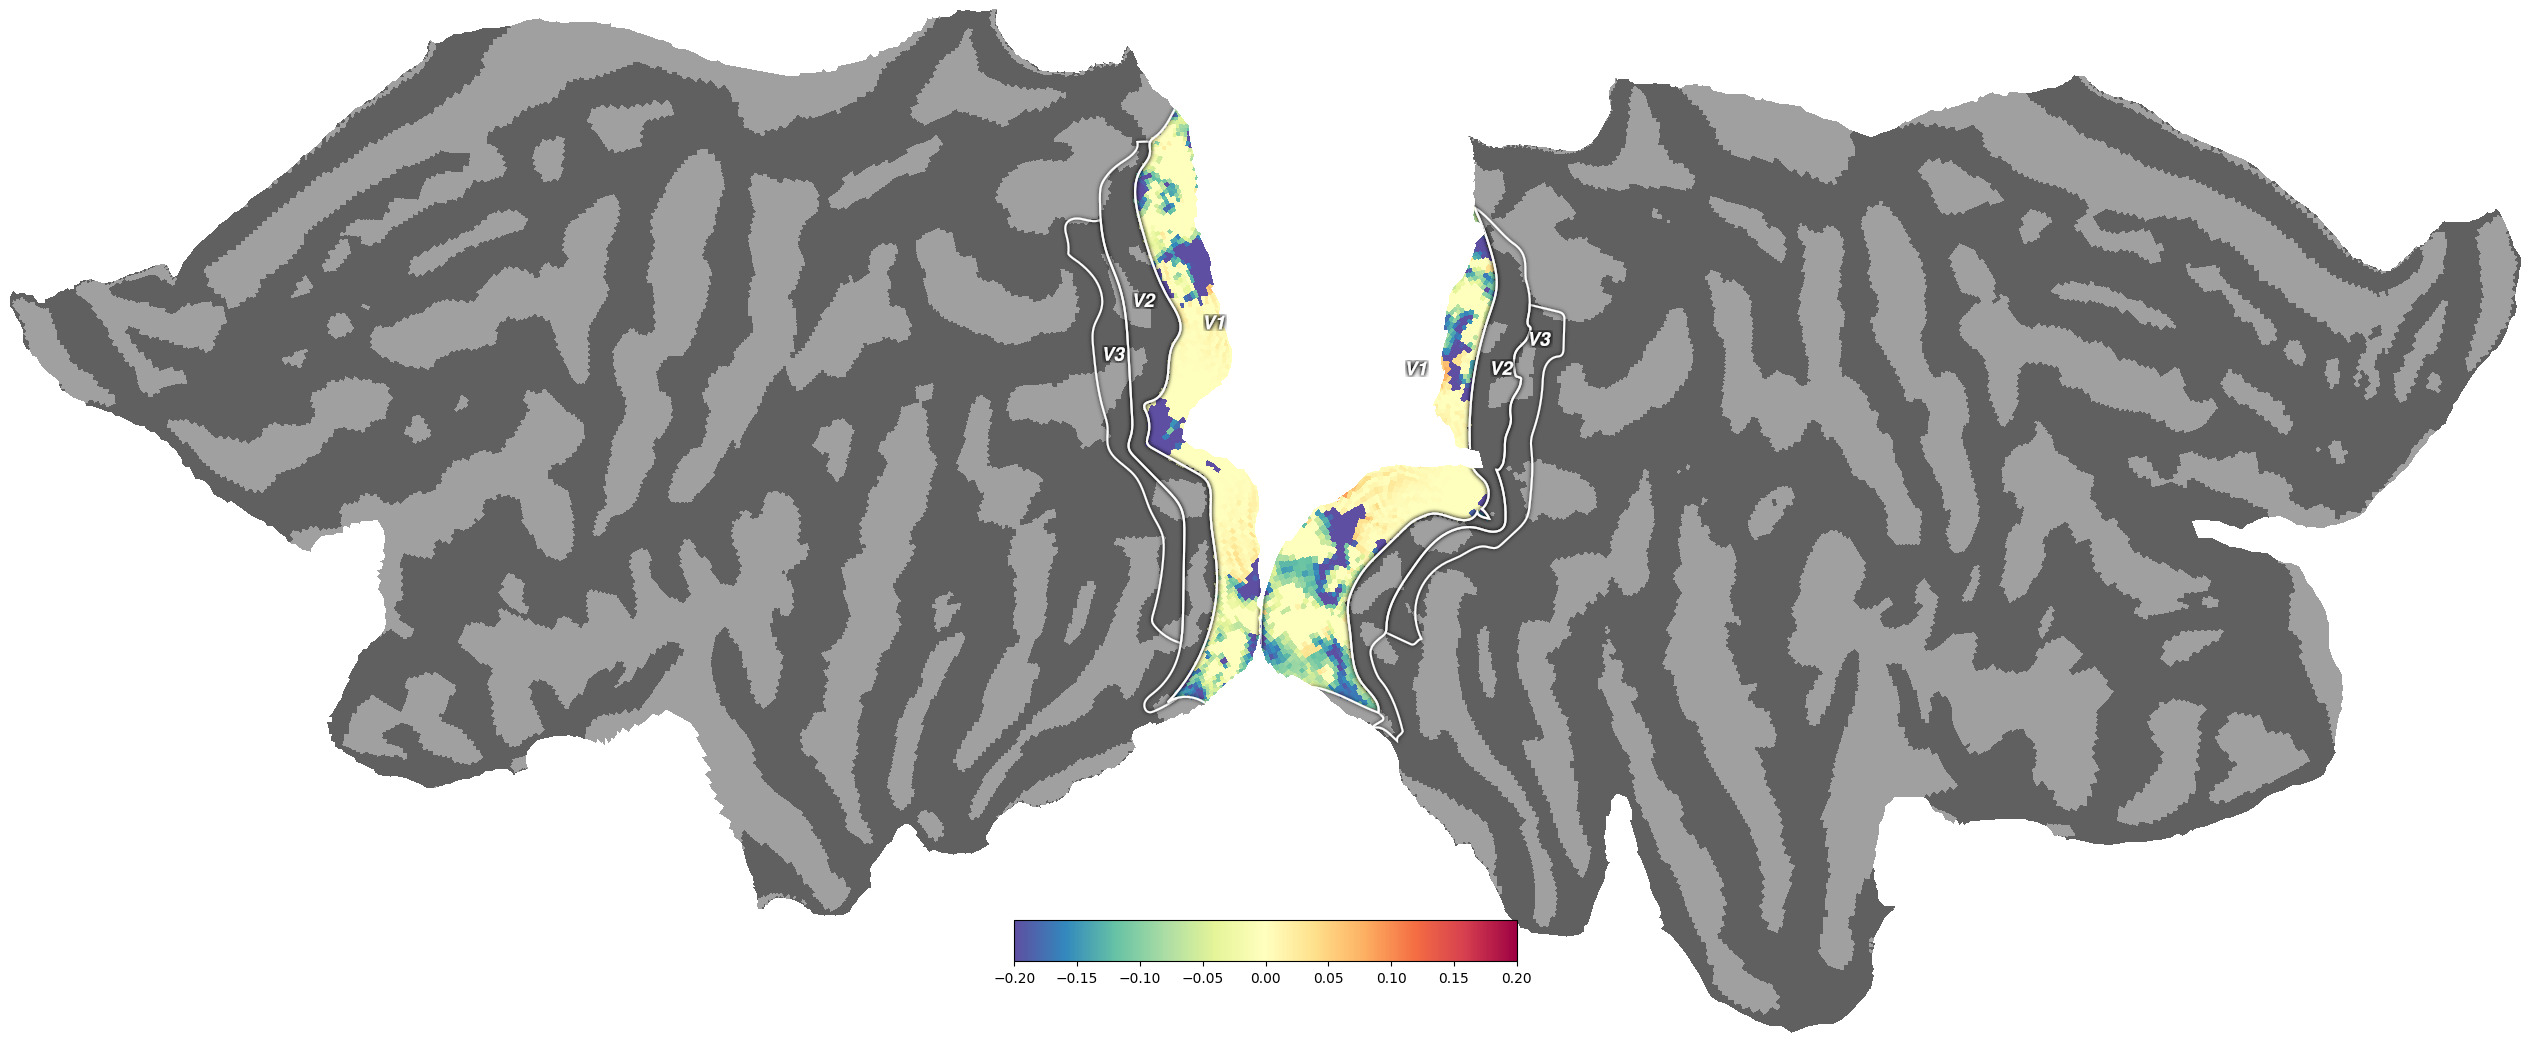

Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B

In [49]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[V1_mask] = gf_P.gridsearch_params[:,-1]
f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=0, vmax=2), with_curvature=True);
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[V1_mask] = gf_P.iterative_search_params[:,-1]
f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=0, vmax=1), with_curvature=True);


In [90]:
gf_P.crossvalidate_fit(get_cortex(np.nan_to_num(s2_f2))[V1_mask])

In [92]:
gf_P.noise_ceiling

array([-2.3503592 , -1.89000177, -1.70527864, ..., -0.21944249,
       -0.13439584, -0.20723617])

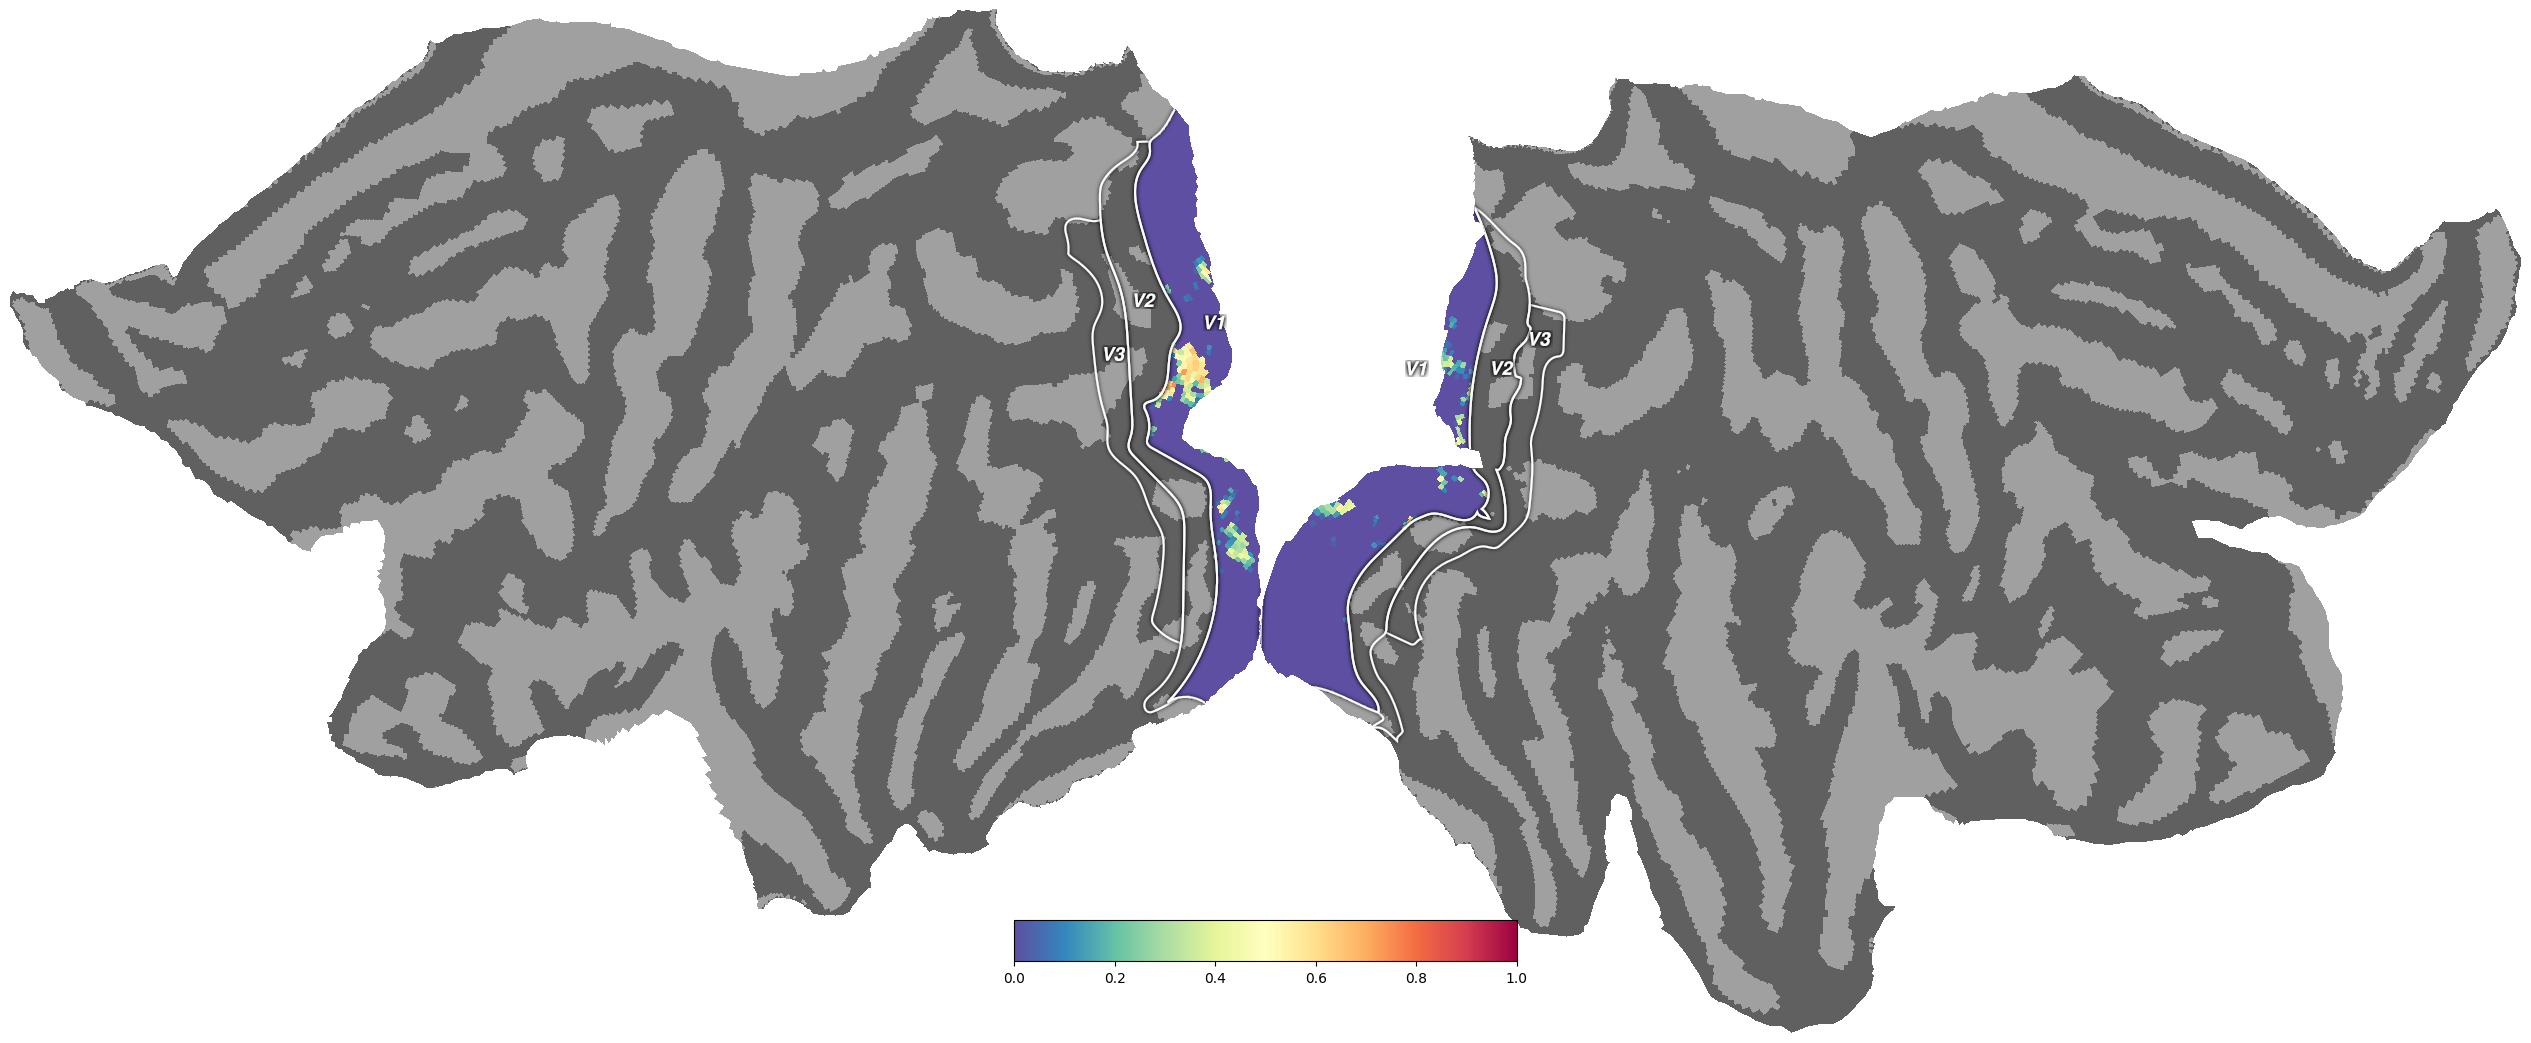

In [93]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[V1_mask] = gf_P.noise_ceiling
f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=0, vmax=1), with_curvature=True);


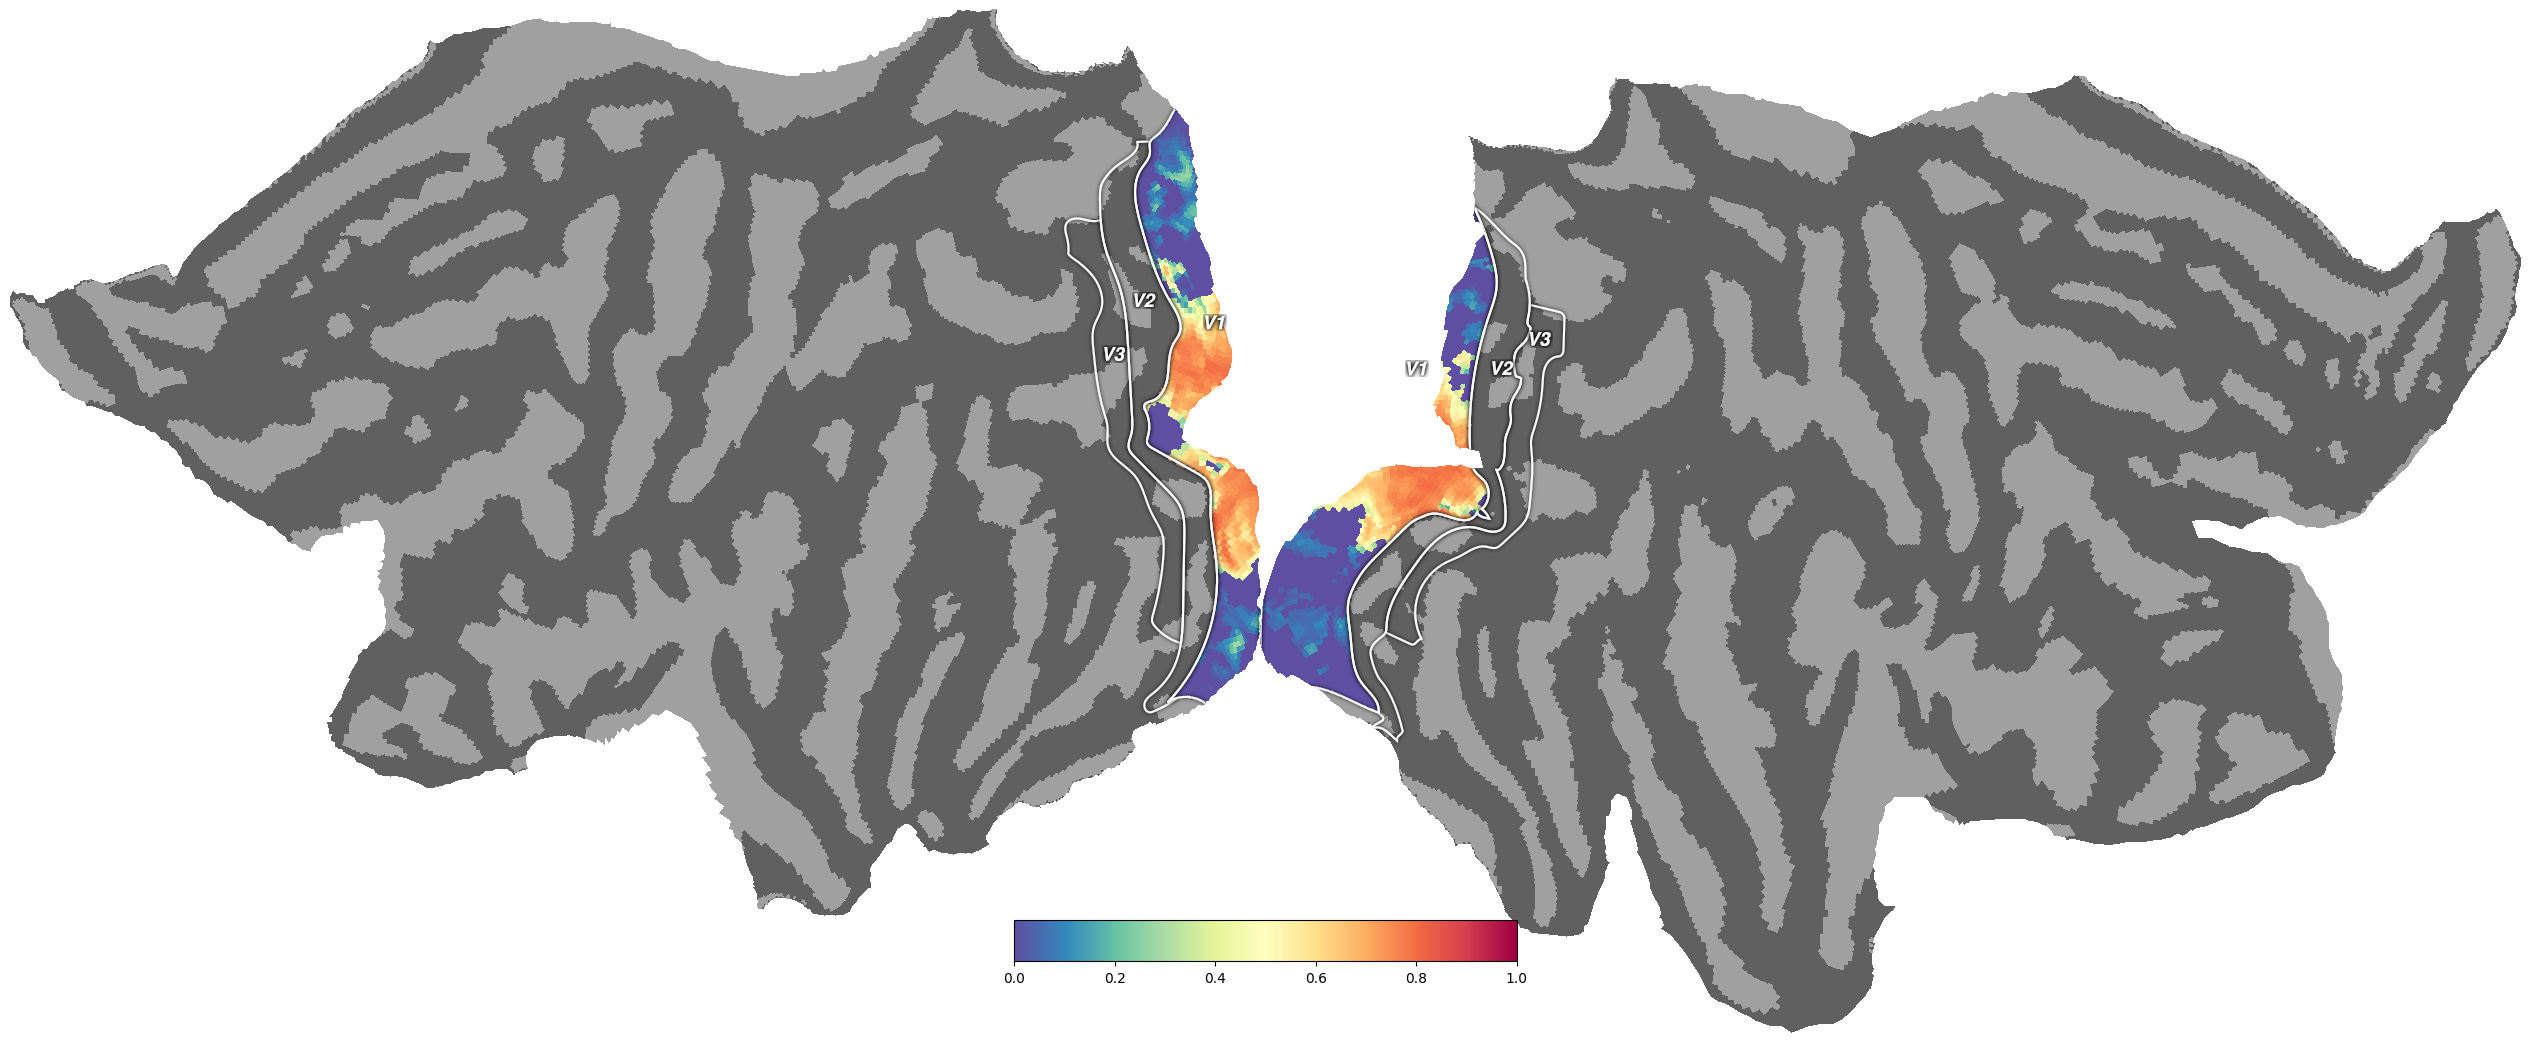

In [24]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[V1_mask] = gf_P.iterative_search_params[:,-1]
f = cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Spectral_r', vmin=0, vmax=1), with_curvature=True);


In [10]:
f = cx.quickshow(cx.Vertex(get_cortex(gf_P.iterative_search_params[:,-1]), subject='hcp_999999', cmap='Spectral_r', vmin=0, vmax=1), with_curvature=True);
# zoom_to_roi('hcp_999999', 'V2', hem='')
f.suptitle('Rsq s2 iterative fit preproc')

NameError: name 'gf_P' is not defined

In [19]:
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel, DoG_Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

In [21]:
gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

gf_norm = Norm_Iso2DGaussianFitter(data=np.nan_to_num(s1_f),
                                   model=gg_norm,
                                   n_jobs=30,
                                   previous_gaussian_fitter=gf_P)

gf_norm.grid_fit(surround_amplitude_grid,
                         surround_size_grid,
                         neural_baseline_grid,
                         surround_baseline_grid,
                         verbose=True,
                         n_batches=60,
                         rsq_threshold=0.01,
                         pos_prfs_only=True)

gf_norm.iterative_fit(rsq_threshold=0.01, verbose=True, bounds=norm_bounds)

gf_norm.crossvalidate_fit(s1_f2,
                 single_hrf=False)

np.save("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy", gf_norm.iterative_search_params)

Each batch contains approx. 2196 voxels.


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed: 11.7min
[Parallel(n_jobs=30)]: Done   7 out of  60 | elapsed: 12.7min remaining: 96.4min
[Parallel(n_jobs=30)]: Done  13 out of  60 | elapsed: 14.8min remaining: 53.4min
[Parallel(n_jobs=30)]: Done  19 out of  60 | elapsed: 15.3min remaining: 32.9min
[Parallel(n_jobs=30)]: Done  25 out of  60 | elapsed: 20.2min remaining: 28.2min
[Parallel(n_jobs=30)]: Done  31 out of  60 | elapsed: 23.0min remaining: 21.5min
[Parallel(n_jobs=30)]: Done  37 out of  60 | elapsed: 25.2min remaining: 15.7min
[Parallel(n_jobs=30)]: Done  43 out of  60 | elapsed: 28.1min remaining: 11.1min
[Parallel(n_jobs=30)]: Done  49 out of  60 | elapsed: 29.1min remaining:  6.5min
[Parallel(n_jobs=30)]: Done  55 out of  60 | elapsed: 32.1min remaining:  2.9min
[Parallel(n_jobs=30)]: Done  60 out of  60 | elapsed: 32.8min finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 conc

In [23]:
np.save('/scratch/2021/nprf_ss/derivatives/prf-fits/sub-01/dn-prf/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy', gf_norm.iterative_search_params)

In [24]:
for sub in range(2):
    print(sub)

0
1
